In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
root_dir = '/root/hoai_workspace/stock-price-prediction/'

# Import

In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

In [4]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers.csv_logs import CSVLogger

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt

In [72]:
class StockTimeSeriesDataset(object):
    def __init__(self, df, history_len, step_len):
        self.history_len = history_len
        self.step_len = step_len

        df['close_log'] = np.log(df['Close'] / df['Close'].shift(1))
        df['vol_log'] = np.log(df['Volume'] / df['Volume'].shift(1))
        df['target_log'] = np.log(df['Close'].shift(-step_len) / df['Close'])
        scaler = MinMaxScaler()
        df.Date = pd.to_datetime(df.Date)
        df['dayofweek'] = df.Date.dt.dayofweek
        df['dayofweek'] = scaler.fit_transform(df['dayofweek'].values.reshape(-1, 1))
        history = []
        target = []
        for i in range(history_len, df.shape[0]-step_len):
            history.append(df[i-history_len+1: i][['close_log', 'vol_log', 'dayofweek']].values)
            target.append(df.loc[i-1, 'target_log'])
        history, target = np.array(history), np.array(target)
        history = np.reshape(history, (history.shape[0], history.shape[1], 3))
        self.history = history
        self.target = target

    def __getitem__(self, idx):
        history = torch.tensor(self.history[idx], dtype=torch.float)        
        target = torch.tensor([self.target[idx]], dtype=torch.float)

        return history, target

    def __len__(self):
        return self.history.shape[0]

In [74]:
class LSTMRegressor(pl.LightningModule):
    '''
    Standard PyTorch Lightning module:
    https://pytorch-lightning.readthedocs.io/en/latest/lightning_module.html
    '''
    def __init__(self):
        super(LSTMRegressor, self).__init__()
        p = dict(
            seq_len = 29,
            batch_size = 64, 
            criterion = nn.MSELoss(),
            max_epochs = 10,
            n_features = 3,
            hidden_size = 50,
            num_layers = 1,
            dropout = 0.8,
            learning_rate = 0.01,
        )
        self.n_features = p['n_features']
        self.hidden_size = p['hidden_size']
        self.seq_len = p['seq_len']
        self.batch_size = p['batch_size']
        self.num_layers = p['num_layers']
        self.dropout = p['dropout']
        self.criterion = p['criterion']
        self.learning_rate = p['learning_rate']

        self.lstm = nn.LSTM(input_size=p['n_features'], 
                            hidden_size=p['hidden_size'],
                            num_layers=p['num_layers'], 
                            dropout=p['dropout'], 
                            batch_first=True)
        self.linear = nn.Linear(p['hidden_size'], 1)
        
    def forward(self, x):
        # lstm_out = (batch_size, seq_len, hidden_size)
        lstm_out, _ = self.lstm(x)
        y_pred = self.linear(lstm_out[:,-1])
        return y_pred
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        # result = pl.TrainResult(loss)
        # result.log('train_loss', loss)
        # Logging to TensorBoard by default
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        # result = pl.EvalResult(checkpoint_on=loss)
        # result.log('val_loss', loss)
        # Logging to TensorBoard by default
        self.log('val_loss', loss)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        # result = pl.EvalResult()
        # result.log('test_loss', loss)
        self.log('test_loss', loss)
        return loss

In [75]:
p = dict(
    seq_len = 29,
    batch_size = 64, 
    criterion = nn.MSELoss(),
    max_epochs = 10,
    n_features = 3,
    hidden_size = 50,
    num_layers = 1,
    dropout = 0.8,
    learning_rate = 0.01,
)

In [76]:
def plot_price(model, df):
    # Get predictions
    # transform=transforms.Compose([transforms.ToTensor(),
    #                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    dataset = StockTimeSeriesDataset(df, 30, 5)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=False, num_workers=2)
    predictions = None
    for i, batch in enumerate(dataloader):
        X, y = batch
        output = model(X)
        if predictions is None:
            predictions = output.cpu().detach().numpy()
        else:
            predictions = np.row_stack([predictions, output.cpu().detach().numpy()])
    # Get target price
    seq_length = 30
    step_length = 5
    df['target_log'] = np.log(df['Close'].shift(-step_length) / df['Close'])
    length = df.shape[0]
    target_price = df[seq_length+step_length:df.shape[0]]['Close']
    inv = df[seq_length:df.shape[0]-step_length]['Close'].values.reshape(-1, 1)
    predicted_price = inv * (np.exp(1) ** predictions)

    # Visualising the results
    date = df[seq_length+step_length:df.shape[0]].Date.values
    plt.figure(figsize=(20,10))
    plt.plot(date, target_price, color = 'red', label = 'Target Price')
    plt.plot(date, predicted_price, color = 'blue', label = 'Predicted Price')
    plt.xticks(np.arange(0,len(predicted_price),100))
    plt.title('TRAIN SET: DJIA Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('DJIA Stock Price')
    plt.legend()
    plt.show()
    print(f'RMSE: {mean_squared_error(target_price, predicted_price, squared=False)}')

In [77]:
df = pd.read_csv(root_dir + 'data/dji_2009-2019.csv')
df['close_log'] = np.log(df['Close'] / df['Close'].shift(1))
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,close_log
0,2009-01-02,8772.250000,9065.280273,8760.780273,9034.690430,9034.690430,213700000,NaN
1,2009-01-05,9027.129883,9034.370117,8892.360352,8952.889648,8952.889648,233760000,-0.009095
2,2009-01-06,8954.570313,9088.059570,8940.950195,9015.099609,9015.099609,215410000,0.006925
3,2009-01-07,8996.940430,8996.940430,8719.919922,8769.700195,8769.700195,266710000,-0.027598
4,2009-01-08,8769.940430,8770.019531,8651.190430,8742.459961,8742.459961,226620000,-0.003111


In [78]:
length = df.shape[0]
train_df = df[:int(length*0.6)].copy()
train_df.reset_index(inplace=True)
val_df = df[int(length*0.6):int(length*0.8)].copy()
val_df.reset_index(inplace=True)
test_df = df[int(length*0.8):].copy()
test_df.reset_index(inplace=True)

In [103]:
checkpoint = 'hoai_workspace/stock-price-prediction/model/lstm_1226_3/dji-volume-dow-notscale-epoch=22-val_loss=0.000225315.ckpt'

In [104]:
model = LSTMRegressor.load_from_checkpoint(checkpoint_path='/root/' + checkpoint)

In [105]:
model.to('cpu');

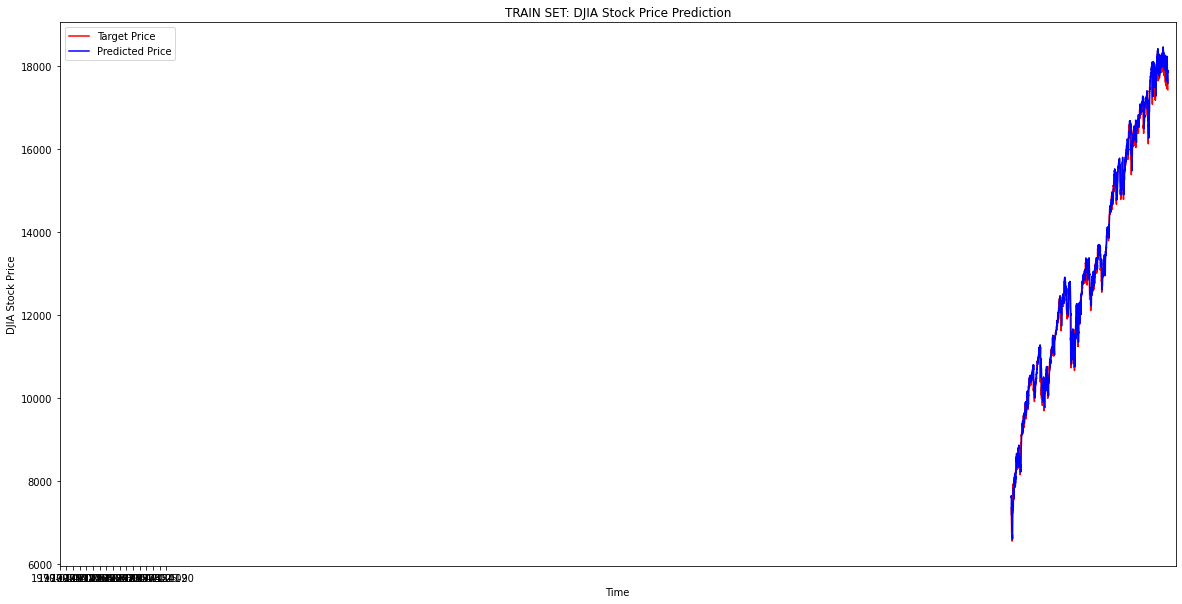

RMSE: 257.66683988040637


In [106]:
plot_price(model, train_df)

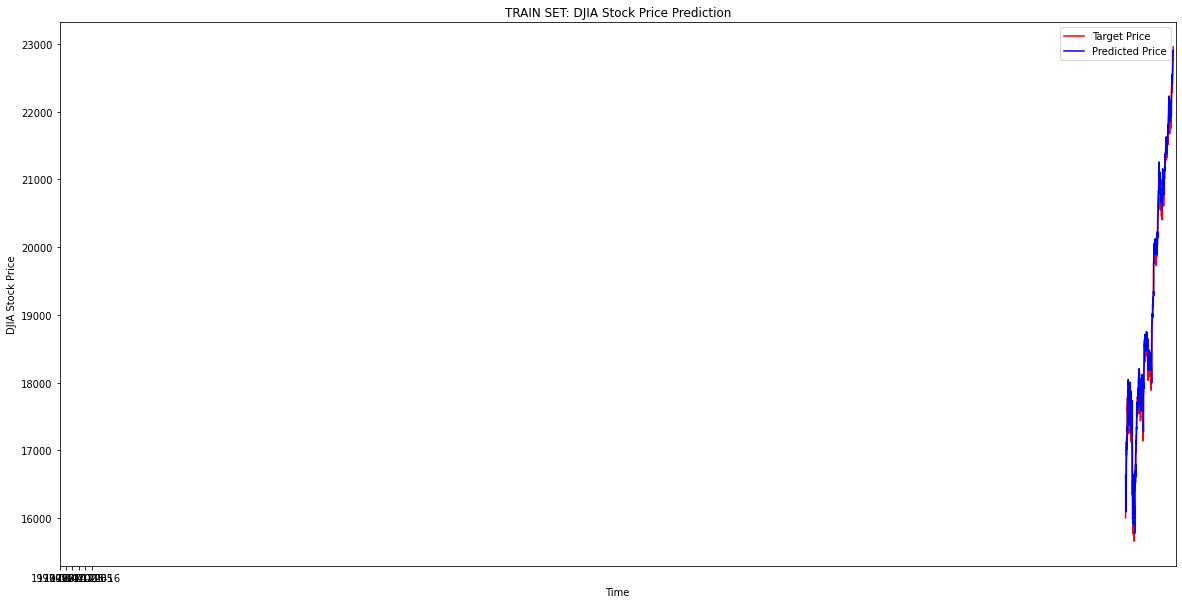

RMSE: 274.51607482425663


In [107]:
plot_price(model, val_df)

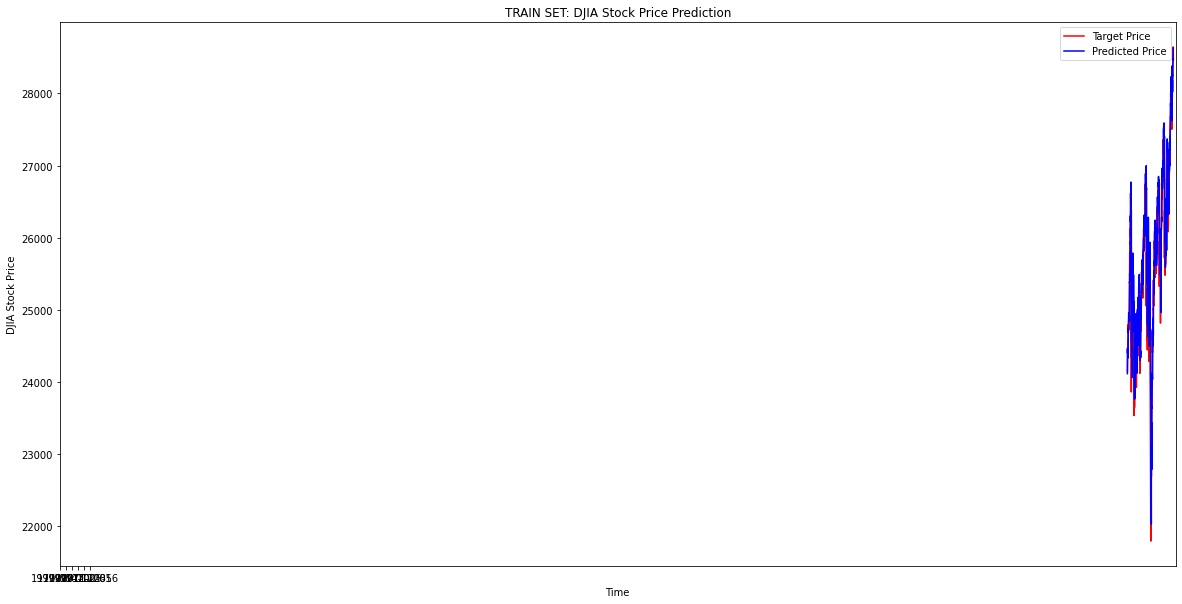

RMSE: 541.6439322188089


In [108]:
plot_price(model, test_df)

In [58]:
df.Date = pd.to_datetime(df.Date)
df['dayofweek'] = df.Date.dt.dayofweek
df['dayofweek'] = scaler.fit_transform(df['dayofweek'].values.reshape(-1, 1))

In [60]:
df['dayofweek'] = df.Date.dt.dayofweek

In [64]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [67]:
df['dayofweek'].values

array([4, 0, 1, ..., 3, 4, 0])

In [69]:
df['dayofweek'] = scaler.fit_transform(df['dayofweek'].values.reshape(-1, 1))

In [71]:
df[:10]

,Date,Open,High,Low,Close,Adj Close,Volume,close_log,dayofweek
0,2009-01-02,8772.250000,9065.280273,8760.780273,9034.690430,9034.690430,213700000,NaN,1.00
1,2009-01-05,9027.129883,9034.370117,8892.360352,8952.889648,8952.889648,233760000,-0.009095,0.00
2,2009-01-06,8954.570313,9088.059570,8940.950195,9015.099609,9015.099609,215410000,0.006925,0.25
3,2009-01-07,8996.940430,8996.940430,8719.919922,8769.700195,8769.700195,266710000,-0.027598,0.50
4,2009-01-08,8769.940430,8770.019531,8651.190430,8742.459961,8742.459961,226620000,-0.003111,0.75
5,2009-01-09,8738.799805,8769.620117,8576.959961,8599.179688,8599.179688,204300000,-0.016525,1.00
6,2009-01-12,8599.259766,8602.599609,8421.080078,8473.969727,8473.969727,273550000,-0.014668,0.00
7,2009-01-13,8474.610352,8522.080078,8376.879883,8448.559570,8448.559570,304050000,-0.003003,0.25
8,2009-01-14,8446.009766,8446.250000,8140.720215,8200.139648,8200.139648,355050000,-0.029845,0.50
9,2009-01-15,8196.240234,8286.160156,7995.129883,8212.490234,8212.490234,436660000,0.001505,0.75
